In [1]:
import numpy as np
import random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
random.seed(0)
np.random.seed(0)


In [2]:
# two blobs = class A (+1)
classA = np.concatenate((
    np.random.randn(10, 2) * 0.2 + [ 1.5,  0.5],
    np.random.randn(10, 2) * 0.2 + [-1.5,  0.5]
))
# one blob = class B (-1)
classB = np.random.randn(20, 2) * 0.2 + [0.0, -0.5]

inputs  = np.concatenate((classA, classB))
targets = np.concatenate(( np.ones(classA.shape[0]),
                          -np.ones(classB.shape[0]) ))

# shuffle once
N = inputs.shape[0]
perm = np.random.permutation(N)
inputs  = inputs[perm]
targets = targets[perm]


In [31]:
def linear_kernel(x, y):
    return float(np.dot(x, y))

def poly_kernel(x, y, degree=2, c=1.0):
    return float((np.dot(x, y) + c) ** degree)

def rbf_kernel(x, y, sigma=1.0):
    diff = x - y
    return float(np.exp(-np.dot(diff, diff) / (2.0 * sigma**2)))

In [32]:
def build_P(X, t, kernel, **kparams):
    N = X.shape[0]
    P = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            P[i, j] = t[i] * t[j] * kernel(X[i], X[j], **kparams)
    return P

def make_objective(P):
    # 0.5 * a^T P a - sum(a)
    return lambda a: 0.5 * a @ P @ a - np.sum(a)

def make_zerofun(t):
    # sum_i alpha_i * t_i = 0
    return lambda a: float(np.dot(a, t))

In [33]:
# choose kernel + its params


kernel  = linear_kernel
kparams = {}    # no extra params

""""
kernel  = poly_kernel
kparams = {'degree': 3, 'c': 1.0}


kernel   = rbf_kernel
kparams  = dict(sigma=1.0)

"""

'"\nkernel  = poly_kernel\nkparams = {\'degree\': 3, \'c\': 1.0}\n\n\nkernel   = rbf_kernel\nkparams  = dict(sigma=1.0)\n\n'

In [34]:


# soft-margin parameter
C = 10.0

P         = build_P(inputs, targets, kernel, **kparams)
objective = make_objective(P)
zerofun   = make_zerofun(targets)
bounds    = [(0, C) for _ in range(N)]
start     = np.zeros(N)
constraint = {'type': 'eq', 'fun': zerofun}

ret = minimize(objective, start, bounds=bounds, constraints=constraint)
if not ret['success']:
    raise RuntimeError(ret['message'])

alpha = ret['x']
alpha[:10]  # peek


array([10.    , 10.    , 10.    , 10.    ,  0.    , 10.    , 10.    ,
        5.1484, 10.    , 10.    ])

In [35]:
def extract_support_vectors(alpha, X, t, thresh=1e-5):
    sv = []
    for i, a in enumerate(alpha):
        if a > thresh:
            sv.append((a, X[i], t[i]))
    return sv

support_vectors = extract_support_vectors(alpha, inputs, targets)
len(support_vectors), support_vectors[0][:2]  # count, first (alpha, x)


(30, (9.999999999968498, array([1.2851, 0.3206])))

In [36]:
def compute_b(sv, kernel, C=None, **kparams):
    if C is None:
        margin = [s for s in sv if s[0] > 1e-5]
    else:
        margin = [s for s in sv if 1e-5 < s[0] < C - 1e-5]
    if not margin:              # fallback if all at bound
        margin = sv
    a_i, x_i, t_i = margin[0]   # pick one
    s = 0.0
    for a_j, x_j, t_j in sv:
        s += a_j * t_j * kernel(x_i, x_j, **kparams)
    return s - t_i

b = compute_b(support_vectors, kernel, C=C, **kparams)
b


0.14770600331855643

In [37]:
def indicator(z, sv, kernel, b, **kparams):
    s = 0.0
    for a_i, x_i, t_i in sv:
        s += a_i * t_i * kernel(z, x_i, **kparams)
    return s - b


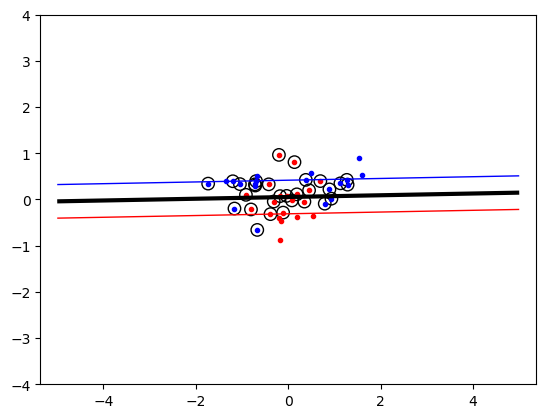

In [38]:
# scatter
plt.plot(classA[:,0], classA[:,1], 'b.')
plt.plot(classB[:,0], classB[:,1], 'r.')

# contours from indicator
xgrid = np.linspace(-5, 5, 200)
ygrid = np.linspace(-4, 4, 200)
grid = np.array([[indicator(np.array([x, y]), support_vectors, kernel, b, **kparams)
                  for x in xgrid] for y in ygrid])

plt.contour(xgrid, ygrid, grid,
            levels=(-1.0, 0.0, 1.0),
            colors=('red', 'black', 'blue'),
            linewidths=(1, 3, 1))

# highlight support vectors
sv_xy = np.array([x for _, x, _ in support_vectors])
plt.scatter(sv_xy[:,0], sv_xy[:,1], s=80, facecolors='none', edgecolors='k')

plt.axis('equal')
plt.show()
